In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
from scipy.io import arff
from sklearn.svm import SVC
import torch

# 1. Electricity dataset

In [56]:
# https://github.com/alipsgh/data_streams
# https://moa.cms.waikato.ac.nz/datasets/
    
data = arff.loadarff('elecNormNew.arff')
df = pd.DataFrame(data[0])

In [57]:
# http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example#one-hot-encoding-column-in-pandas-dataframe
df.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,b'2',0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,b'UP'
1,0.0,b'2',0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,b'UP'
2,0.0,b'2',0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,b'UP'
3,0.0,b'2',0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,b'UP'
4,0.0,b'2',0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,b'DOWN'


In [58]:
df = pd.concat([df, pd.get_dummies(df['day'], prefix='day')], axis=1).drop(['day'], axis=1)

In [59]:
df = pd.concat([df.drop(['date', 'period', 'class'], axis=1), df['class'].map(lambda x: 1 if x == b'UP' else -1)], axis=1)

In [60]:
df.head()

,nswprice,nswdemand,vicprice,vicdemand,transfer,day_b'1',day_b'2',day_b'3',day_b'4',day_b'5',day_b'6',day_b'7',class
0,0.056443,0.439155,0.003467,0.422915,0.414912,0,1,0,0,0,0,0,1
1,0.051699,0.415055,0.003467,0.422915,0.414912,0,1,0,0,0,0,0,1
2,0.051489,0.385004,0.003467,0.422915,0.414912,0,1,0,0,0,0,0,1
3,0.045485,0.314639,0.003467,0.422915,0.414912,0,1,0,0,0,0,0,1
4,0.042482,0.251116,0.003467,0.422915,0.414912,0,1,0,0,0,0,0,-1


In [61]:
x = df.drop(['class'], axis=1).values
y = df['class'].values
print(x.shape, y.shape)

bulk = 6750
x_train, y_train = x[:bulk], y[:bulk]
x_test, y_test = x[bulk:], y[bulk:]

(45312, 12) (45312,)


## 1.2 SVM Classifier (Electricity)

In [62]:
gamma = 1.0 / (x_train.shape[1] * x.var())
print(f'gamma: {gamma}')
clf = SVC(gamma=gamma)
clf.fit(x_train, y_train)

gamma: 0.8360009752209537


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.8360009752209537,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [63]:
acc = np.sum(clf.predict(x_test) == y_test)

In [64]:
c_svm = acc * 100 / len(y_test)
print(f'Accurracy: {acc}/{len(y_test)} {c_svm}%')

Accurracy: 26285/38562 68.16295835278254%


In [65]:
#first = x[0]
#x[0] = x[4]
#x[4] = first

In [66]:
#first = y[0]
#y[0] = y[4]
#y[4] = first

In [67]:
#d = {'x': torch.tensor(x), 'y': torch.tensor(y)}
#torch.save(d, 'electricity.pt')

## 1.3 Processing training results

In [68]:
# read file
res = pd.read_csv('../experiments/running_electricity_ws_155_fsize_100.csv')
res = res.values
res = res[:-99]
# res = None
# with open('../experiments/running_electricity_ws_155_fsize_100.csv') as f:
#     line = f.readline()
    
#     size = None
#     while line is not None:
#         l = np.array([int(x) for x in line.split(',')])
#         size = len(l) if size is None else size
        
#         if len(l) < size:
#             break
            
#         if res is None:
#             res = l.reshape(1, -1)
#         else:
#             res = np.vstack([res, l])
            
#         line = f.readline()
#         if l[0] % 1000 == 0:
#             print(f'{l[0]}')

In [69]:
def ewa(x, beta):
    # v_t = beta * v_{t-1} + (1 - beta) * x_t
    # corr = 1 / ( 1 - beta ** t)
    
    corr = beta
    v = np.zeros_like(x)
    
    v[0] = x[0]
    for i in range(1, len(x)):
        v[i] = beta * v[i-1] + (1 - beta) * x[i]
        
    return v

In [70]:
def accplot(res, f_size, beta=0.9995):
    x = res[:, 0]
    y = res[:, 1:f_size + 1].sum(axis=1) * 100 / f_size # always set this to be percents
    y_ewa = ewa(y, beta) # 1/(1-beta) values, here 2000 values

    # plot the entire data
    rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    ax.plot(x, y, lw=1, linestyle='-')
    ax.plot(x, y_ewa, lw=2, c='k')
    ax.plot([x[0], x[-1]], [y.mean(), y.mean()], c='red', linestyle='-', lw=2)
    ax.set_xlim([x[0], x[-1]])
    ax.set_ylabel('accuracy [%]')
    ax.set_xlabel('epoch')
    ax.legend([f'{f_size} epochs', f'ewa {f_size} epochs', f'mean {np.round(y.mean(), 2)}%'])
    plt.grid(); plt.show()
    
    return y_ewa, y.mean()

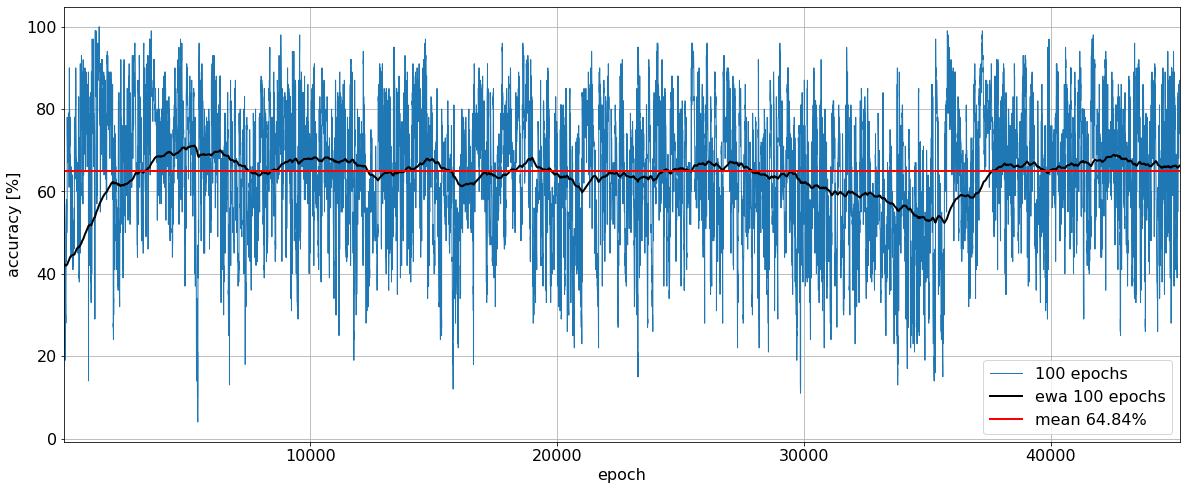

In [71]:
y_ewa_100, y_mean_100 = accplot(res, f_size=100, beta=0.9995)

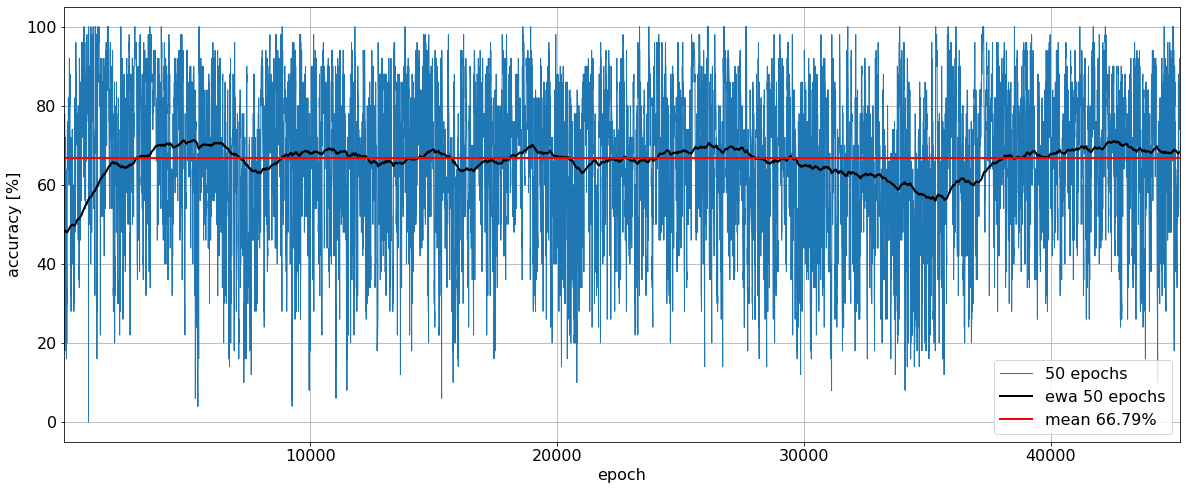

In [72]:
# compute for a future size of 50
y_ewa_50, y_mean_50 = accplot(res, f_size=50, beta=0.9995)

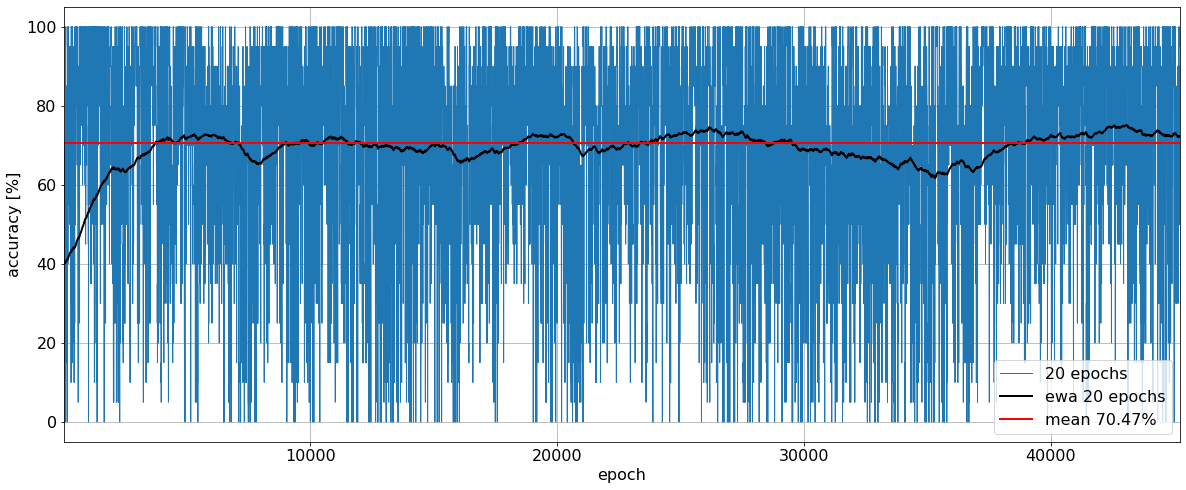

In [73]:
# compute for a future size of 20
y_ewa_20, y_mean_20 = accplot(res, f_size=20, beta=0.9995)

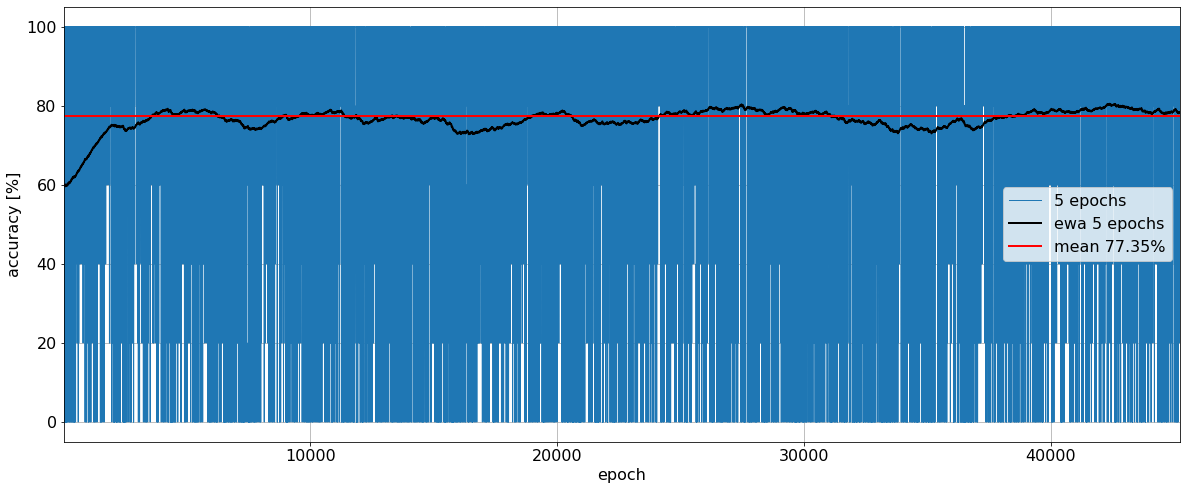

In [74]:
# compute for a future size of 5
y_ewa_5, y_mean_5 = accplot(res, f_size=5, beta=0.9995)

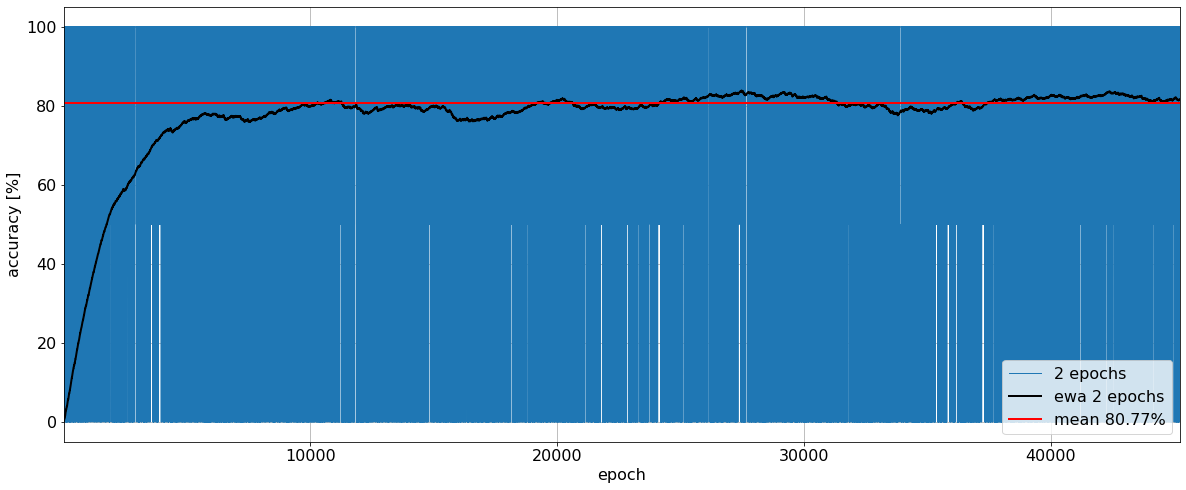

In [75]:
# compute for a future size of 2
y_ewa_2, y_mean_2 = accplot(res, f_size=2, beta=0.9995)

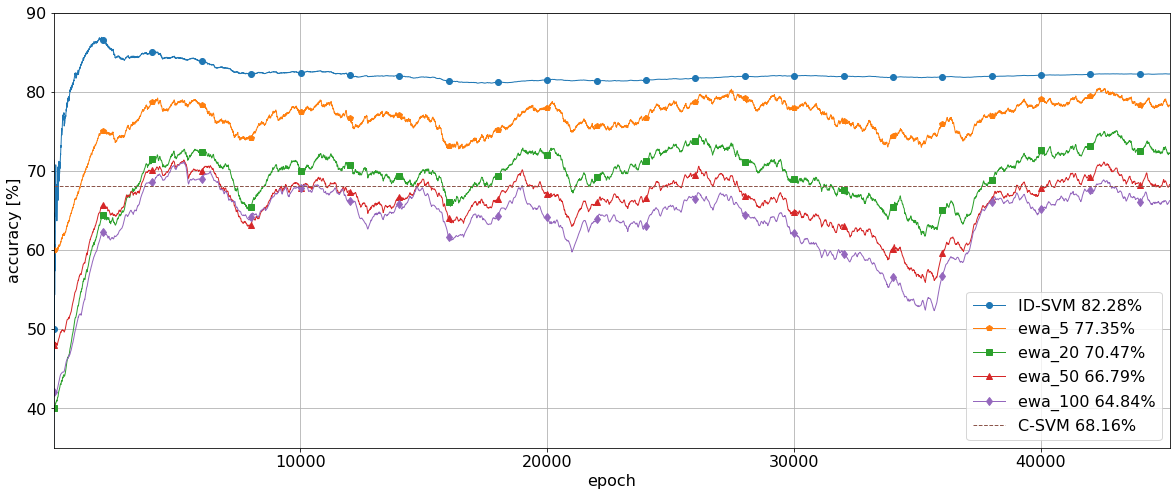

82.27825702278257

In [77]:
# represent running accuracy
x = res[:, 0].astype(int)
y = res[:, 1].copy().astype(np.float)

tot = 1
acc = y[0] 
for i in range(1, len(x)):
    tot += 1
    acc += y[i]
    y[i] = acc * 100 / tot

# plot the entire data
rcParams.update({'font.size': 16})
mke = range(x[0], x[-1], 2000)
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(x, y, lw=1, linestyle='-', marker='o', markevery=mke)
ax.plot(x, y_ewa_5, lw=1, linestyle='-', marker='p', markevery=mke)
ax.plot(x, y_ewa_20, lw=1, linestyle='-', marker='s', markevery=mke)
ax.plot(x, y_ewa_50, lw=1, linestyle='-', marker='^', markevery=mke)
ax.plot(x, y_ewa_100, lw=1, linestyle='-', marker='d', markevery=mke)
ax.plot([x[0], x[-1]], [c_svm, c_svm], linestyle='--', lw=1)
ax.set_xlim([x[0], x[-1]])
ax.set_ylim(35, 90)
ax.set_ylabel('accuracy [%]')
ax.set_xlabel('epoch')
#ax.legend([f'ID-SVM {np.round(y[-1], 2)}%', 'ewa_100', 'ewa_50', f'ewa_20', 'ewa_5', f'C-SVM {np.round(c_svm, 2)}%'])
ax.legend([f'ID-SVM {np.round(y[-1], 2)}%', 
           f'ewa_5 {str(round(y_mean_5, 2))}%',
           f'ewa_20 {str(round(y_mean_20, 2))}%',
           f'ewa_50 {str(round(y_mean_50, 2))}%',           
           f'ewa_100 {str(round(y_mean_100, 2))}%', 
           f'C-SVM {np.round(c_svm, 2)}%'])

plt.grid(); plt.show()
y[-1]

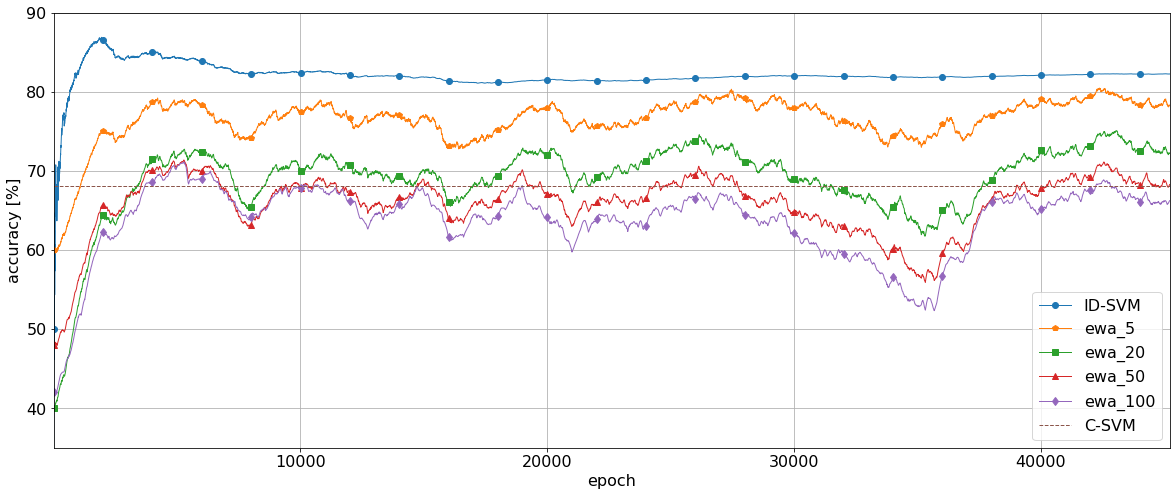

82.27825702278257

In [78]:
# represent running accuracy
x = res[:, 0].astype(int)
y = res[:, 1].copy().astype(np.float)

tot = 1
acc = y[0] 
for i in range(1, len(x)):
    tot += 1
    acc += y[i]
    y[i] = acc * 100 / tot

# plot the entire data
rcParams.update({'font.size': 16})
mke = range(x[0], x[-1], 2000)
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(x, y, lw=1, linestyle='-', marker='o', markevery=mke)
ax.plot(x, y_ewa_5, lw=1, linestyle='-', marker='p', markevery=mke)
ax.plot(x, y_ewa_20, lw=1, linestyle='-', marker='s', markevery=mke)
ax.plot(x, y_ewa_50, lw=1, linestyle='-', marker='^', markevery=mke)
ax.plot(x, y_ewa_100, lw=1, linestyle='-', marker='d', markevery=mke)
ax.plot([x[0], x[-1]], [c_svm, c_svm], linestyle='--', lw=1)
ax.set_xlim([x[0], x[-1]])
ax.set_ylim(35, 90)
ax.set_ylabel('accuracy [%]')
ax.set_xlabel('epoch')
#ax.legend([f'ID-SVM {np.round(y[-1], 2)}%', 'ewa_100', 'ewa_50', f'ewa_20', 'ewa_5', f'C-SVM {np.round(c_svm, 2)}%'])
ax.legend([f'ID-SVM', f'ewa_5', f'ewa_20', f'ewa_50', f'ewa_100', f'C-SVM'])
plt.grid(); plt.show()
y[-1]

# 2. Forest Covertype

In [2]:
fdata = arff.loadarff('covtypeNorm.arff')
fdf = pd.DataFrame(fdata[0])

In [3]:
fdf.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [4]:
fdf.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.582677,0.875366,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'5'
1,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.594488,0.867838,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'5'
2,0.472736,0.386111,0.136364,0.191840,0.307494,0.446817,0.921260,0.937008,0.531496,0.853339,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'2'
3,0.463232,0.430556,0.272727,0.173228,0.375969,0.434172,0.937008,0.937008,0.480315,0.865886,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'2'
4,0.368184,0.125000,0.030303,0.109520,0.222222,0.054939,0.866142,0.921260,0.590551,0.860449,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'5'


In [5]:
fdf['class'].head()


0    b'5'
1    b'5'
2    b'2'
3    b'2'
4    b'5'
Name: class, dtype: object

In [6]:
fdf['class'].map(lambda x: int(x)).head()

0    5
1    5
2    2
3    2
4    5
Name: class, dtype: int64

In [7]:
for i in range(1, 5):
    fdf[f'Wilderness_Area{i}'] = fdf[f'Wilderness_Area{i}'].map(lambda x: int(x))

In [8]:
for i in range(1, 41):
    fdf[f'Soil_Type{i}'] = fdf[f'Soil_Type{i}'].map(lambda x: int(x))

In [9]:
fdf['class'] = fdf['class'].map(lambda x: int(x))

In [10]:
set(fdf['class'])

{1, 2, 3, 4, 5, 6, 7}

In [11]:
print(f'total: {len(fdf)}')

for i in range(1, 8):
    print(f"class{i}: {len(fdf[fdf['class'] == i])}")

total: 581012
class1: 211840
class2: 283301
class3: 35754
class4: 2747
class5: 9493
class6: 17367
class7: 20510


In [12]:
subset_fdf = fdf[fdf['class'].isin([1, 2])].copy()
subset_fdf['class'] = subset_fdf['class'].map(lambda x: 2*(x-1) - 1)

x = subset_fdf.drop(['class'], axis=1).values
y = subset_fdf['class'].values
print(x.shape, y.shape)

(495141, 54) (495141,)


In [13]:
for i in range(len(y)):
    if y[i] == -1:
        print(i)
        break

9


In [14]:
first = x[0] ; x[0] = x[9] ; x[9] = first
first = y[0] ; y[0] = y[9] ; y[9] = first

In [15]:
n = 100 # was: 2000
x_train = x[:n]
y_train = y[:n]

In [16]:
# determine the longest window of elements belonging to a single class
def contiguous_intervals(y):
    wins = {-1: [], 1: []}
    start, length, win_type = 0, 1, y[0]
    for i in range(1, len(y)):
        if y[i] == y[i-1]:
            length += 1
        else:
            wins[win_type].append((start, length))
            start, length, win_type = i, 1, y[i]
    wins[win_type].append((start, length))
    return wins

wins = contiguous_intervals(y)

In [17]:
wins[-1].sort(key=lambda tup: tup[1], reverse=True)
wins[-1][:10]

[(392672, 265),
 (393080, 256),
 (391083, 255),
 (342879, 253),
 (348388, 251),
 (347780, 250),
 (391490, 250),
 (391889, 248),
 (350863, 247),
 (392283, 244)]

In [18]:
wins[1].sort(key=lambda tup: tup[1], reverse=True)
wins[1][:10]

[(489449, 5692),
 (36124, 296),
 (36521, 294),
 (36915, 294),
 (35730, 293),
 (210967, 288),
 (29479, 287),
 (27936, 284),
 (28321, 284),
 (28707, 284)]

In [19]:
# eliminate last interval of class 1
y_prel = y[:wins[1][0][0]]
x_prel = x[:wins[1][0][0]]
wins[1] = wins[1][1:]
print(x_prel.shape, y_prel.shape)

(489449, 54) (489449,)


In [20]:
# iterate through all the intervals and exchange element before first with middle
def exchange(win, x, y):
    for start, length in win:
        if length > 100:
            t = x[start + length // 2]
            x[start + length // 2] = x[start - 1]
            x[start - 1] = t
            t = y[start + length // 2]
            y[start + length // 2] = y[start - 1]
            y[start - 1] = t
            
exchange(wins[-1], x_prel, y_prel)
exchange(wins[1], x_prel, y_prel)

In [21]:
wins = contiguous_intervals(y_prel)

In [22]:
wins[-1].sort(key=lambda tup: tup[1], reverse=True)
wins[-1][:10]

[(392671, 133),
 (392805, 132),
 (453552, 131),
 (393079, 129),
 (391082, 128),
 (342878, 127),
 (391211, 127),
 (393209, 127),
 (343006, 126),
 (347779, 126)]

In [23]:
wins[1].sort(key=lambda tup: tup[1], reverse=True)
wins[1][:10]

[(36123, 149),
 (36520, 148),
 (36914, 148),
 (35729, 147),
 (36273, 146),
 (36669, 146),
 (37063, 146),
 (35877, 145),
 (210966, 145),
 (29478, 144)]

## 2.2 SVM Classifier (Forest Covertype)

In [24]:
%%time
gamma = 1.0 / (x_train.shape[1] * x.var())
print(f'gamma: {gamma}')
clf = SVC(gamma=gamma)
clf.fit(x_train, y_train)

gamma: 0.24147042669967936
CPU times: user 93 ms, sys: 36.2 ms, total: 129 ms
Wall time: 128 ms


In [38]:
import time
n=2300

k = 0
for i in range(10):
    t = np.zeros(100)
    for j in range(100):
        
        x_train = x[n + k : n + k + n]
        y_train = y[n + k : n + k + n]
        
        gamma = 1.0 / (x_train.shape[1] * x.var())
        
        tic = time.perf_counter()
        clf = SVC(gamma=gamma)
        clf.fit(x_train, y_train)
        toc = time.perf_counter()
        
        t[j] = toc - tic
        k += 1
    print(f'{t.mean():.5f} [s]')

0.32282 [s]
0.31663 [s]
0.31139 [s]
0.31434 [s]
0.29863 [s]
0.27536 [s]
0.28380 [s]
0.25882 [s]
0.25012 [s]
0.23879 [s]


In [37]:
print(x_train.shape)

(1000, 54)


In [102]:
np.sum(clf.predict(x_train) == y_train) / len(x_train)

0.77575

In [103]:
d = {'x': torch.tensor(x_prel), 'y': torch.tensor(y_prel)}
torch.save(d, 'covertype.pt')

In [104]:
len(y_prel)

489449

In [105]:
x_train = x_prel[:12000]
y_train = y_prel[:12000]
x_test = x_prel[12000:]
y_test = y_prel[12000:]

In [106]:
gamma = 1.0 / (x_train.shape[1] * x.var())
print(f'gamma: {gamma}')
clf = SVC(gamma=gamma)
clf.fit(x_train, y_train)

gamma: 0.24147042669967936


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.24147042669967936,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [107]:
print(x_train.shape)
print(x_test.shape)

(12000, 54)
(477449, 54)


In [108]:
acc = np.sum(clf.predict(x_test) == y_test)

In [109]:
c_svm = acc * 100 / len(y_test)
print(f'Accurracy: {acc}/{len(y_test)} {c_svm}%')

Accurracy: 364581/477449 76.36019763367396%


In [110]:
y_prel[6384], y_prel[6385], y_prel[6386]

(1, -1, 1)

In [111]:
wins = contiguous_intervals(y_prel)
wins[-1][150:]

[(836, 3),
 (843, 5),
 (851, 2),
 (860, 1),
 (869, 2),
 (872, 2),
 (875, 1),
 (877, 1),
 (880, 2),
 (883, 1),
 (885, 1),
 (889, 1),
 (892, 1),
 (894, 2),
 (897, 1),
 (904, 2),
 (907, 2),
 (914, 2),
 (920, 1),
 (926, 3),
 (932, 2),
 (936, 1),
 (939, 2),
 (942, 1),
 (945, 1),
 (949, 4),
 (954, 1),
 (956, 1),
 (958, 6),
 (965, 4),
 (970, 1),
 (972, 1),
 (974, 1),
 (976, 1),
 (978, 2),
 (984, 1),
 (988, 1),
 (994, 2),
 (997, 1),
 (999, 1),
 (1001, 6),
 (1008, 1),
 (1010, 1),
 (1012, 4),
 (1019, 2),
 (1024, 1),
 (1027, 7),
 (1036, 1),
 (1040, 1),
 (1043, 8),
 (1052, 1),
 (1055, 4),
 (1060, 8),
 (1069, 1),
 (1073, 1),
 (1075, 1),
 (1077, 2),
 (1080, 3),
 (1084, 2),
 (1087, 1),
 (1089, 2),
 (1093, 1),
 (1095, 2),
 (1098, 1),
 (1100, 1),
 (1102, 3),
 (1106, 6),
 (1113, 3),
 (1119, 1),
 (1122, 4),
 (1132, 1),
 (1134, 1),
 (1136, 1),
 (1139, 4),
 (1145, 9),
 (1158, 2),
 (1161, 3),
 (1167, 2),
 (1171, 7),
 (1179, 3),
 (1183, 2),
 (1187, 2),
 (1191, 1),
 (1193, 1),
 (1195, 7),
 (1203, 1),
 (1205, 

In [112]:
wins[1]

[(1, 11),
 (15, 2),
 (18, 10),
 (29, 1),
 (31, 1),
 (34, 1),
 (36, 9),
 (46, 7),
 (54, 4),
 (59, 1),
 (62, 3),
 (66, 1),
 (68, 1),
 (70, 12),
 (83, 3),
 (88, 2),
 (91, 5),
 (97, 3),
 (102, 4),
 (107, 3),
 (112, 2),
 (116, 3),
 (120, 1),
 (122, 2),
 (126, 3),
 (130, 2),
 (133, 1),
 (137, 2),
 (141, 2),
 (144, 2),
 (147, 4),
 (152, 1),
 (155, 1),
 (157, 3),
 (161, 4),
 (169, 3),
 (173, 1),
 (175, 3),
 (179, 2),
 (182, 4),
 (188, 4),
 (193, 1),
 (195, 1),
 (197, 4),
 (203, 4),
 (208, 2),
 (212, 1),
 (214, 1),
 (216, 2),
 (219, 1),
 (221, 12),
 (235, 1),
 (238, 4),
 (243, 4),
 (250, 4),
 (256, 5),
 (262, 2),
 (265, 2),
 (270, 2),
 (275, 1),
 (280, 1),
 (282, 3),
 (287, 1),
 (289, 5),
 (297, 2),
 (302, 11),
 (314, 2),
 (319, 3),
 (323, 8),
 (333, 2),
 (336, 5),
 (342, 3),
 (351, 1),
 (354, 2),
 (357, 3),
 (361, 2),
 (364, 4),
 (369, 10),
 (380, 3),
 (384, 2),
 (387, 1),
 (390, 1),
 (392, 6),
 (399, 2),
 (402, 2),
 (406, 1),
 (410, 2),
 (413, 6),
 (420, 7),
 (428, 4),
 (433, 1),
 (436, 4),
 

# 2.3 Results post-processing

In [113]:
res_files = 'running_019054.csv running_028295.csv running_034934.csv running_038366.csv running_096567.csv ' \
    'running_202080.csv running_205490.csv running_216617.csv running_260495.csv running_266587.csv ' \
    'running_267694.csv running_273330.csv running_274415.csv running_278234.csv running_278819.csv ' \
    'running_285012.csv running_286938.csv running_355504.csv running_376841.csv running_386947.csv ' \
    'running_433510.csv running_443110.csv running_473013.csv running_489448.csv'

In [114]:
res_files.split()

['running_019054.csv',
 'running_028295.csv',
 'running_034934.csv',
 'running_038366.csv',
 'running_096567.csv',
 'running_202080.csv',
 'running_205490.csv',
 'running_216617.csv',
 'running_260495.csv',
 'running_266587.csv',
 'running_267694.csv',
 'running_273330.csv',
 'running_274415.csv',
 'running_278234.csv',
 'running_278819.csv',
 'running_285012.csv',
 'running_286938.csv',
 'running_355504.csv',
 'running_376841.csv',
 'running_386947.csv',
 'running_433510.csv',
 'running_443110.csv',
 'running_473013.csv',
 'running_489448.csv']

In [115]:
# read files
l = []
for f in res_files.split():
    block = pd.read_csv('covertype_data/' + f)
    l += [block.values]

res = np.vstack(l)
del l
res = res[:-99]

In [116]:
for i in range(1, res.shape[0]):
    res[i][0] = i

In [117]:
res.shape

(487712, 101)

/home/honorius/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


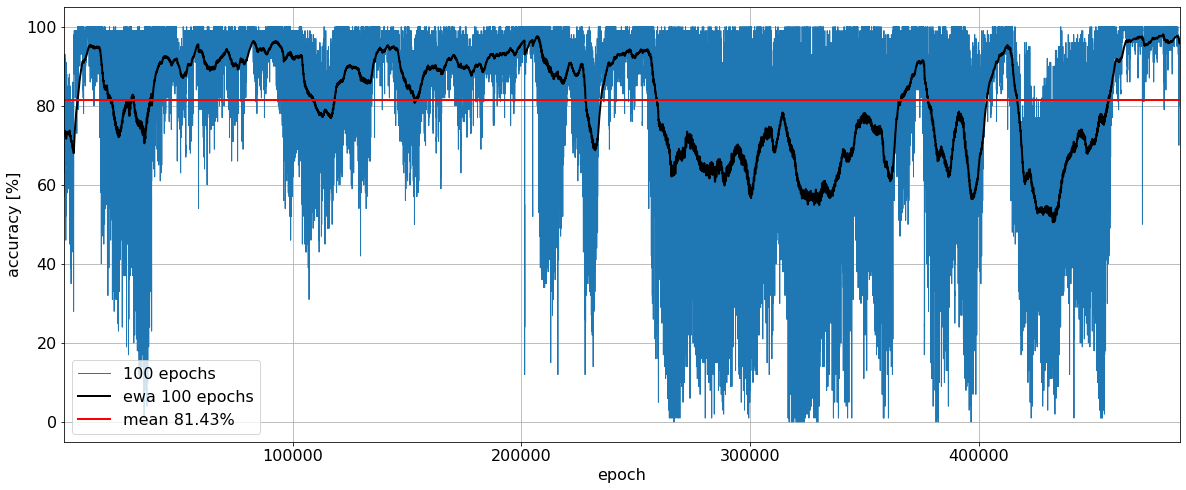

In [118]:
# beta = 0.9995 -> last 2000 epochs (default)
# beta = 0.995 -> last 200 epochs
# beta = 0.95 -> last 20 epochs
y_ewa_100, y_mean_100 = accplot(res, f_size=100, beta=0.9995)

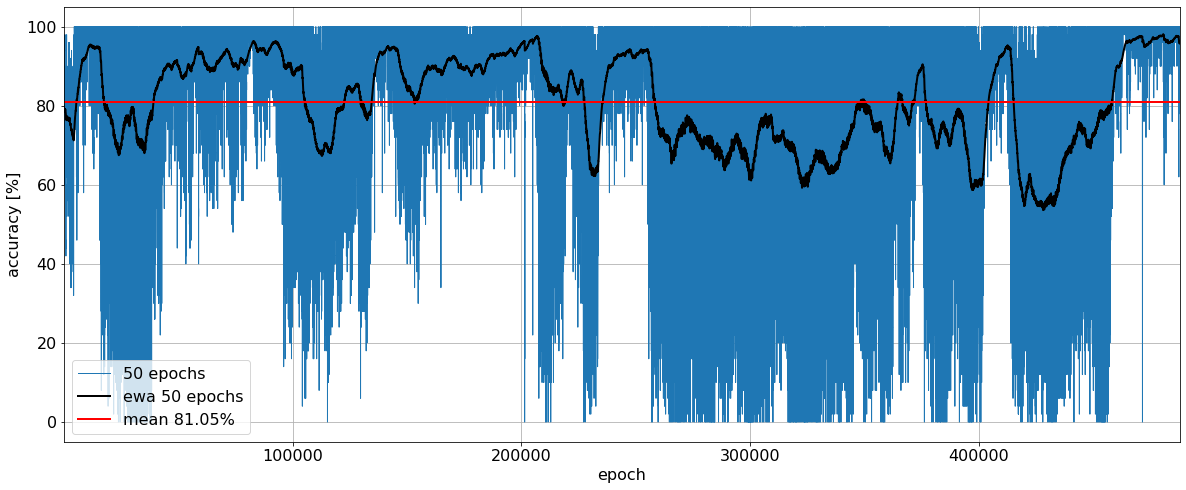

In [119]:
# compute for a future size of 50
y_ewa_50, y_mean_50 = accplot(res, f_size=50, beta=0.9995)

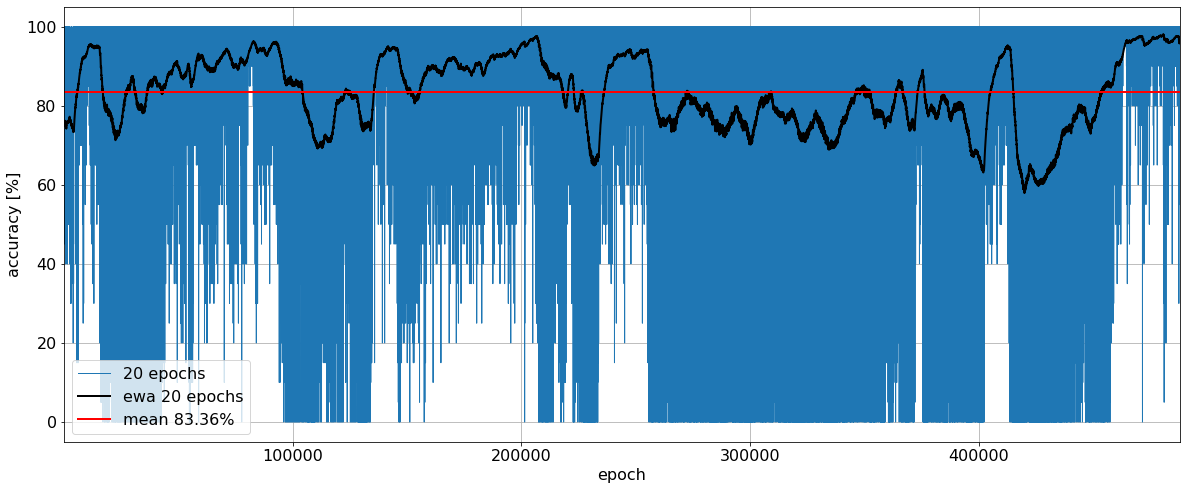

In [120]:
# compute for a future size of 20
y_ewa_20, y_mean_20 = accplot(res, f_size=20, beta=0.9995)

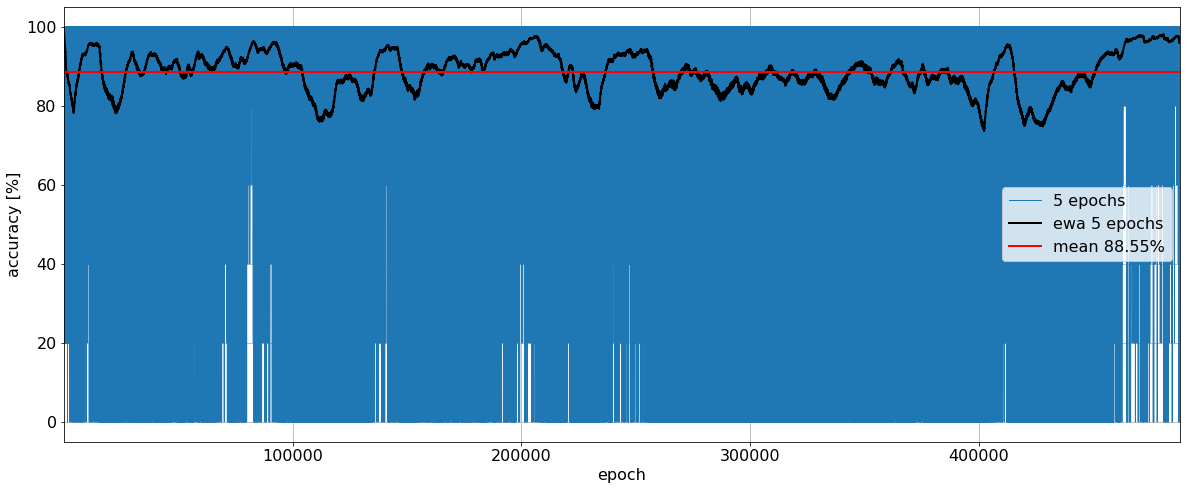

In [121]:
# compute for a future size of 5
y_ewa_5, y_mean_5 = accplot(res, f_size=5, beta=0.9995)

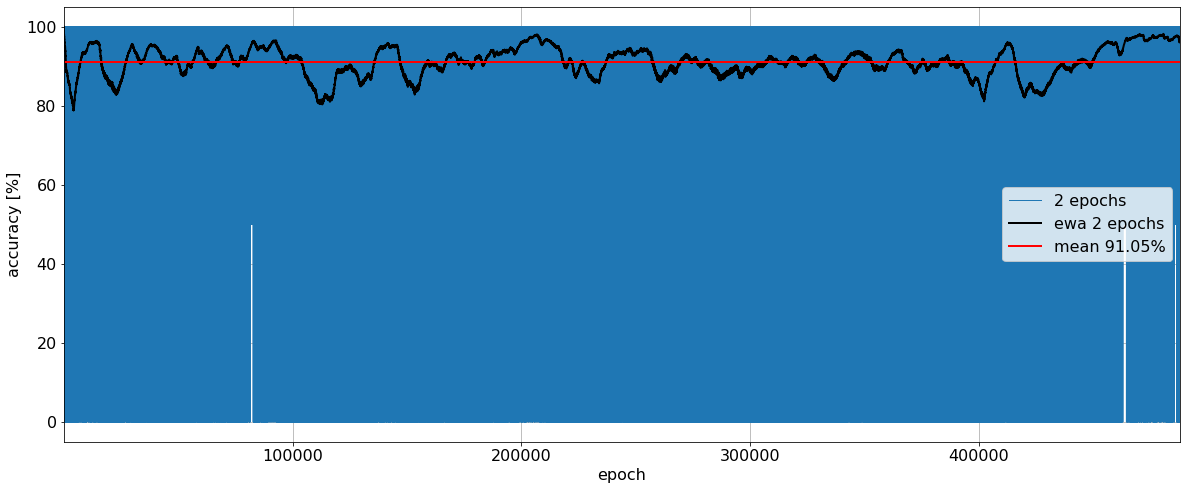

In [122]:
# compute for a future size of 2
y_ewa_2, y_mean_2 = accplot(res, f_size=2, beta=0.9995)

In [123]:
def decimate(x, y_ewa, every=5000):
    sx = x[[x[i] % every == 0 for i in range(0, len(x))]]
    sy_ewa = y_ewa[[x[i] % every == 0 for i in range(0, len(x))]]
    for i in range(1, len(x)-1):
        if i % every == 0:
            sy_ewa[i//every - 1] = y_ewa[i-every : i].mean()
    return sx, sy_ewa

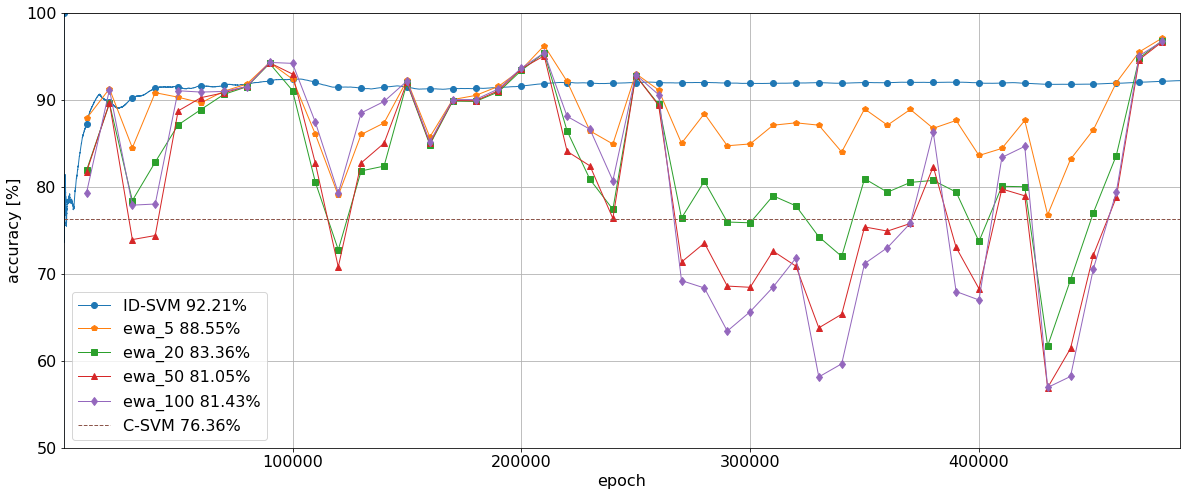

92.21241224329113

In [124]:
# represent running accuracy
x = np.array(range(int(res[0, 0]), int(res[0, 0] + res.shape[0])))
y = res[:, 1].copy().astype(np.float)

tot = 1
acc = y[0] 
for i in range(1, len(x)):
    tot += 1
    acc += y[i]
    y[i] = acc * 100 / tot
    
sx, sy_ewa_100 = decimate(x, y_ewa_100, 10000)
_, sy_ewa_50 = decimate(x, y_ewa_50, 10000)
_, sy_ewa_20 = decimate(x, y_ewa_20, 10000)
_, sy_ewa_5 = decimate(x, y_ewa_5, 10000)

# plot the entire data
rcParams.update({'font.size': 16})
mke = range(x[0], x[-1], 10000)
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(x, y, lw=1, linestyle='-', marker='o', markevery=mke)
# ax.plot(x, sy_ewa_100, lw=1, linestyle='-', marker='d', markevery=mke)
# ax.plot(x, y_ewa_50, lw=0, linestyle='-', marker='^', markevery=mke)
# ax.plot(x, y_ewa_20, lw=0, linestyle='-', marker='s', markevery=mke)
# ax.plot(x, y_ewa_5, lw=0, linestyle='-', marker='p', markevery=mke)
ax.plot(sx, sy_ewa_5, lw=1, linestyle='-', marker='p', markevery=1)
ax.plot(sx, sy_ewa_20, lw=1, linestyle='-', marker='s', markevery=1)
ax.plot(sx, sy_ewa_50, lw=1, linestyle='-', marker='^', markevery=1)
ax.plot(sx, sy_ewa_100, lw=1, linestyle='-', marker='d', markevery=1)
ax.plot([x[0], x[-1]], [c_svm, c_svm], linestyle='--', lw=1)
ax.set_xlim([x[0], x[-1]])
ax.set_ylim(50, 100)
ax.set_ylabel('accuracy [%]')
ax.set_xlabel('epoch')
ax.legend([f'ID-SVM {np.round(y[-1], 2)}%',            
           f'ewa_5 {str(round(y_mean_5, 2))}%',
           f'ewa_20 {str(round(y_mean_20, 2))}%',
           f'ewa_50 {str(round(y_mean_50, 2))}%',
           f'ewa_100 {str(round(y_mean_100, 2))}%', 
           f'C-SVM {np.round(c_svm, 2)}%'])
plt.grid(); plt.show()
y[-1]

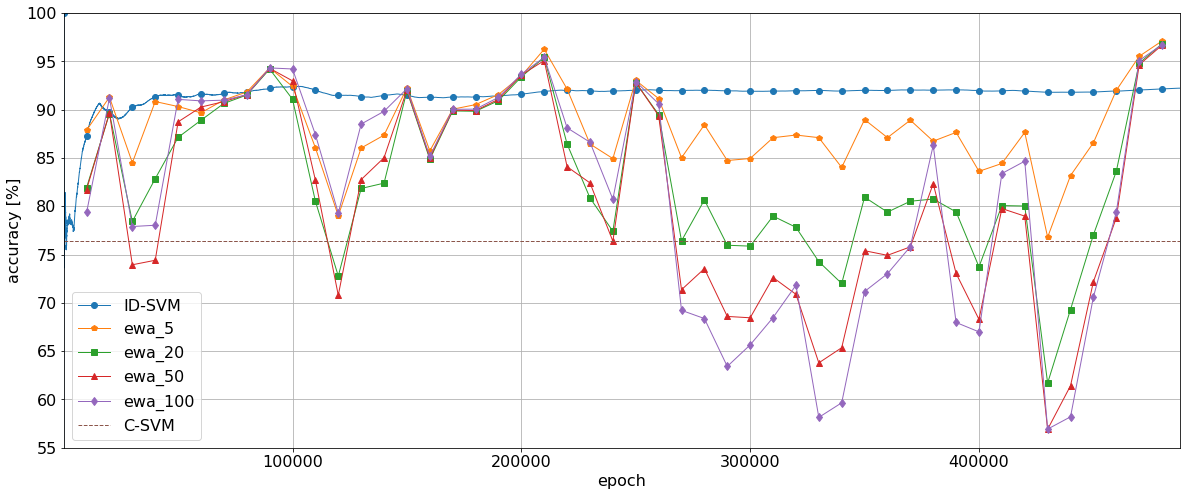

92.21241224329113

In [126]:
# represent running accuracy
x = np.array(range(int(res[0, 0]), int(res[0, 0] + res.shape[0])))
y = res[:, 1].copy().astype(np.float)

tot = 1
acc = y[0] 
for i in range(1, len(x)):
    tot += 1
    acc += y[i]
    y[i] = acc * 100 / tot
    
sx, sy_ewa_100 = decimate(x, y_ewa_100, 10000)
_, sy_ewa_50 = decimate(x, y_ewa_50, 10000)
_, sy_ewa_20 = decimate(x, y_ewa_20, 10000)
_, sy_ewa_5 = decimate(x, y_ewa_5, 10000)

# plot the entire data
rcParams.update({'font.size': 16})
mke = range(x[0], x[-1], 10000)
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(x, y, lw=1, linestyle='-', marker='o', markevery=mke)
# ax.plot(x, sy_ewa_100, lw=1, linestyle='-', marker='d', markevery=mke)
# ax.plot(x, y_ewa_50, lw=0, linestyle='-', marker='^', markevery=mke)
# ax.plot(x, y_ewa_20, lw=0, linestyle='-', marker='s', markevery=mke)
# ax.plot(x, y_ewa_5, lw=0, linestyle='-', marker='p', markevery=mke)
ax.plot(sx, sy_ewa_5, lw=1, linestyle='-', marker='p', markevery=1)
ax.plot(sx, sy_ewa_20, lw=1, linestyle='-', marker='s', markevery=1)
ax.plot(sx, sy_ewa_50, lw=1, linestyle='-', marker='^', markevery=1)
ax.plot(sx, sy_ewa_100, lw=1, linestyle='-', marker='d', markevery=1)
ax.plot([x[0], x[-1]], [c_svm, c_svm], linestyle='--', lw=1)
ax.set_xlim([x[0], x[-1]])
ax.set_ylim(55, 100)
ax.set_ylabel('accuracy [%]')
ax.set_xlabel('epoch')
ax.legend([f'ID-SVM', f'ewa_5', f'ewa_20', f'ewa_50', f'ewa_100', f'C-SVM'])
plt.grid(); plt.show()
y[-1]

In [110]:
range(int(x[0]), int(x[-1]), 489349)

range(3, 487714, 489349)

# 3. Stagger

In [23]:
res = None
for i in range(1, 101):
    name = f'stagger/stagger_w_50_n_0.1/stagger_w_50_n_0.1_{100 + i}.arff'
    print(f'processing {name} ...', end='\r', flush=True)
    data = arff.loadarff(name)
    df = pd.DataFrame(data[0])
    
    df = pd.concat([df, pd.get_dummies(df['size'], prefix='size')], axis=1).drop(['size'], axis=1)
    df = pd.concat([df, pd.get_dummies(df['color'], prefix='color')], axis=1).drop(['color'], axis=1)
    df = pd.concat([df, pd.get_dummies(df['shape'], prefix='shape')], axis=1).drop(['shape'], axis=1)
    df = pd.concat([df.drop(['class'], axis=1), 2*(df['class'] == b'p') - 1], axis=1)
    
    if res is None:
        res = df.values
    else:
        res = np.vstack([res, df.values])

In [24]:
a = res[0]
b = res[3]
res = np.vstack([b, res[1:3], a, res[4:]])

In [25]:
res = torch.tensor(res).float()
d = {'x': res[:, :7], 'y': res[:, 7]}

In [26]:
torch.save(d, 'stagger/stagger.pt')

# 3.1 SVM training

In [43]:
n = 100000
x_train = res[:n, :7].float()
y_train = res[:n, 7].float()
res = res.float()

In [44]:
gamma = 1.0 / (x_train.shape[1] * res[:,:7].var())
print(f'gamma: {gamma}')
clf = SVC(gamma=gamma)
clf.fit(x_train, y_train)

gamma: 0.5833333134651184


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=tensor(0.5833), kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [45]:
x_test = res[n:, :7]
y_test = res[n:, 7]

In [53]:
torch.sum(torch.tensor(clf.predict(x_train)) == y_train).float() / len(x_train)

tensor(0.6780)

In [ ]:
torch.sum(torch.tensor(clf.predict(x_test)) == y_test).float() / len(x_test)

# 4. Circles

In [3]:
data = arff.loadarff('circles/circles_w_500_n_0.1/circles_w_500_n_0.1_101.arff')
df = pd.DataFrame(data[0])

In [4]:
res = None
for i in range(1, 11):
    name = f'circles/circles_w_500_n_0.1/circles_w_500_n_0.1_{i + 100}.arff'
    print(f'processing {name} ...', end='\r', flush=True)
    data = arff.loadarff(name)
    df = pd.DataFrame(data[0])
    
    #df = pd.concat([df, pd.get_dummies(df['size'], prefix='size')], axis=1).drop(['size'], axis=1)
    #df = pd.concat([df, pd.get_dummies(df['color'], prefix='color')], axis=1).drop(['color'], axis=1)
    #df = pd.concat([df, pd.get_dummies(df['shape'], prefix='shape')], axis=1).drop(['shape'], axis=1)
    df = pd.concat([df.drop(['class'], axis=1), 2*(df['class'] == b'p') - 1], axis=1)
    
    if res is None:
        res = df.values
    else:
        res = np.vstack([res, df.values])

In [5]:
a = res[0]
b = res[3]
res = np.vstack([b, res[1:3], a, res[4:]])

In [6]:
res = torch.tensor(res).float()
d = {'x': res[:, :2], 'y': res[:, 2]}

In [132]:
#torch.save(d, 'circles/circles.pt')

# 4.1 SVM training

In [50]:
n = 1000
x_train = res[:n, :2].float()
y_train = res[:n, 2].float()
res = res.float()

In [51]:
%%time
gamma = 1.0 / (x_train.shape[1] * res[:,:2].var())
print(f'gamma: {gamma}')
clf = SVC(gamma=gamma)
clf.fit(x_train, y_train)

gamma: 7.801543712615967
CPU times: user 201 ms, sys: 0 ns, total: 201 ms
Wall time: 146 ms


In [135]:
res.shape

torch.Size([1000000, 3])

In [136]:
x_test = res[n:, :2]
y_test = res[n:, 2]

In [137]:
torch.sum(torch.tensor(clf.predict(x_train)) == y_train).float() / len(x_train)

tensor(0.8714)

In [138]:
acc = torch.sum(torch.tensor(clf.predict(x_test)) == y_test).float()

In [139]:
c_svm = acc.item() * 100 / len(y_test)
print(f'Accurracy: {acc}/{len(y_test)} {c_svm}%')

Accurracy: 591058.0/990000 59.702828282828285%


In [140]:
np.round(c_svm, 2)

59.7

## 4.2 Results post-processing for Circle

In [141]:
df = pd.read_csv('circles_data/running_circles.csv')

In [142]:
df.shape

(972998, 51)

In [143]:
res = df.values

/home/honorius/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


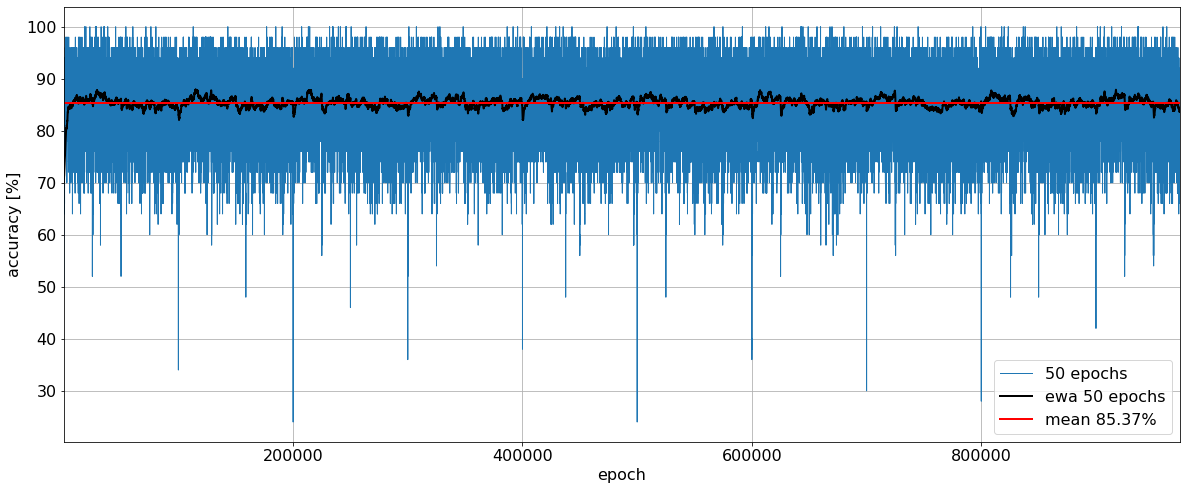

In [144]:
# beta = 0.9995 -> last 2000 epochs (default)
# beta = 0.995 -> last 200 epochs
# beta = 0.95 -> last 20 epochs
y_ewa_50, y_mean_50 = accplot(res, f_size=50, beta=0.9995)

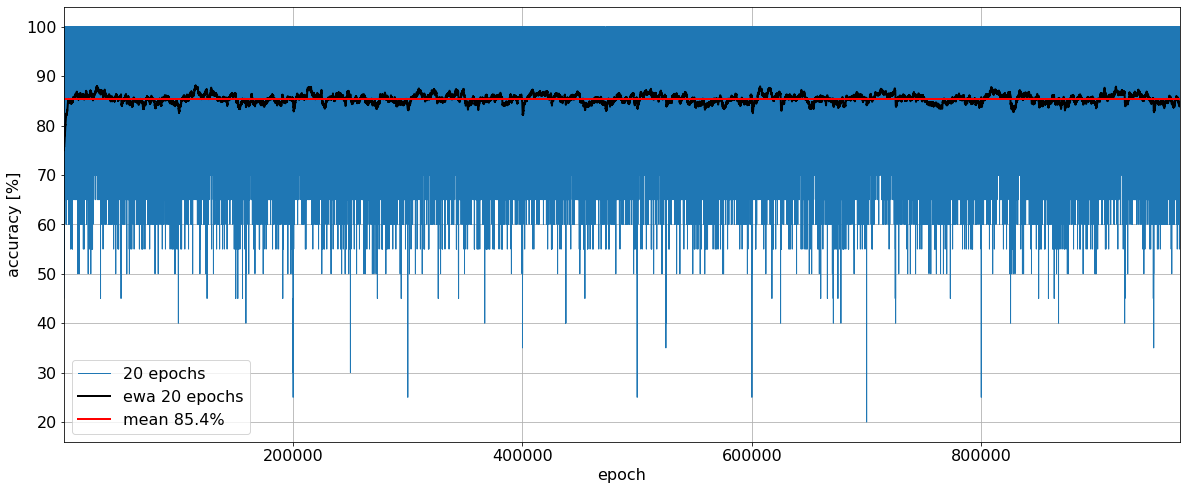

In [145]:
# compute for a future size of 20
y_ewa_20, y_mean_20 = accplot(res, f_size=20, beta=0.9995)

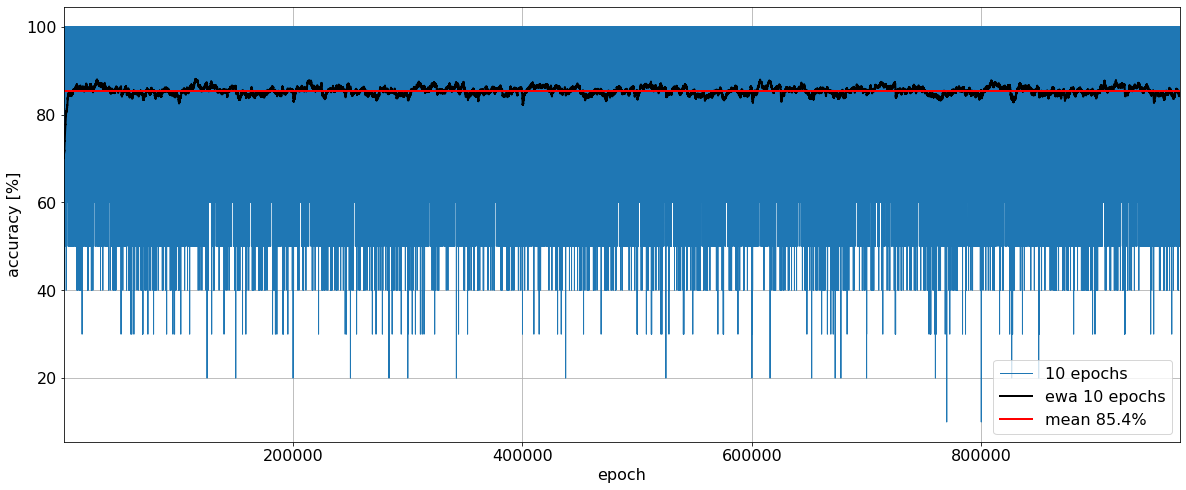

In [146]:
# compute for a future size of 10
y_ewa_10, y_mean_10 = accplot(res, f_size=10, beta=0.9995)

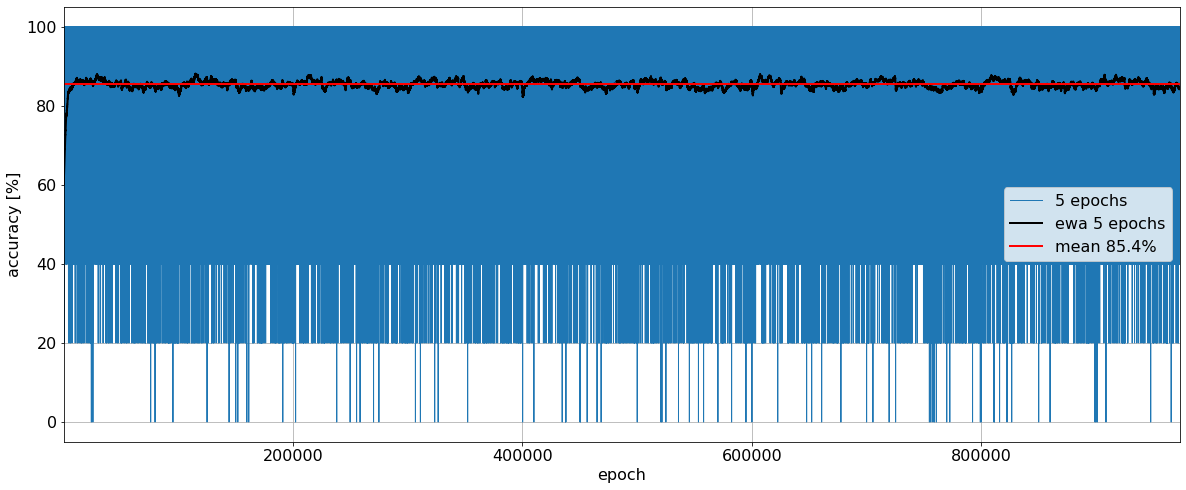

In [147]:
# compute for a future size of 5
y_ewa_5, y_mean_5 = accplot(res, f_size=5, beta=0.9995)

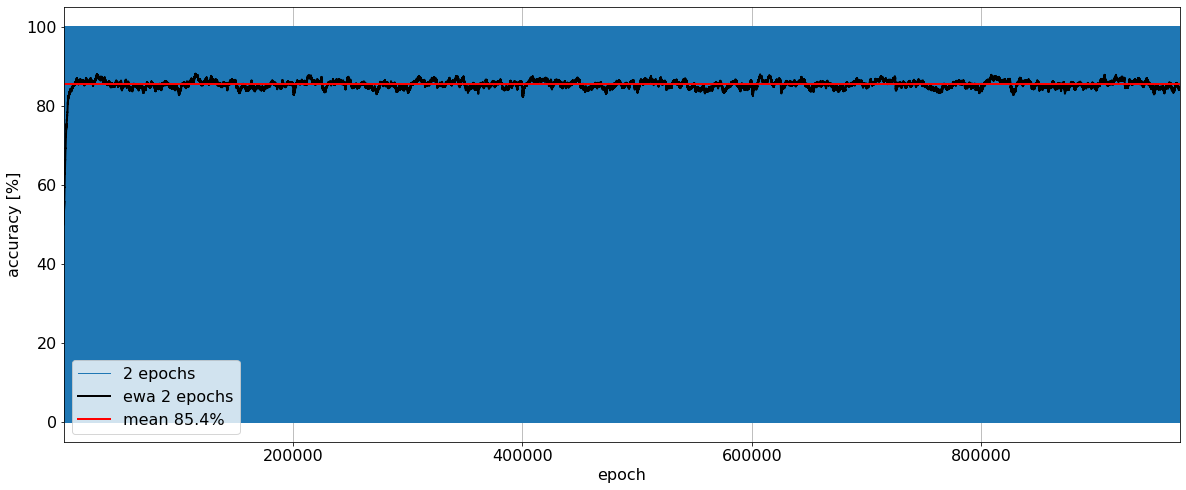

In [148]:
# compute for a future size of 2
y_ewa_2, y_mean_2 = accplot(res, f_size=2, beta=0.9995)

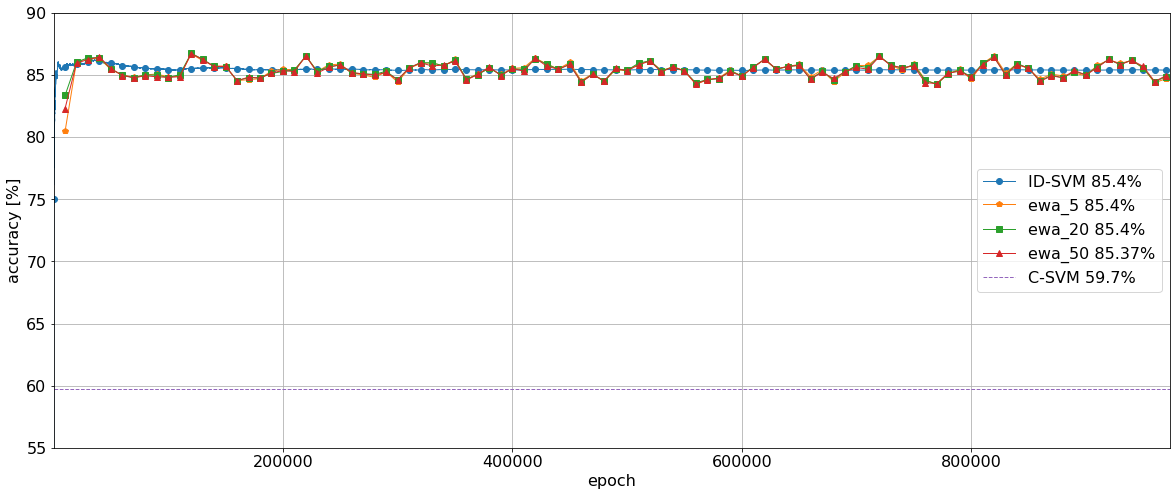

85.39760616157484

In [150]:
# represent running accuracy
x = np.array(range(int(res[0, 0]), int(res[0, 0] + res.shape[0])))
y = res[:, 1].copy().astype(np.float)

tot = 1
acc = y[0] 
for i in range(1, len(x)):
    tot += 1
    acc += y[i]
    y[i] = acc * 100 / tot
    
sx, sy_ewa_50 = decimate(x, y_ewa_50, 10000)
_, sy_ewa_20 = decimate(x, y_ewa_20, 10000)
_, sy_ewa_5 = decimate(x, y_ewa_5, 10000)

# plot the entire data
rcParams.update({'font.size': 16})
mke = range(x[0], x[-1], 10000)
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(x, y, lw=1, linestyle='-', marker='o', markevery=mke)
# ax.plot(x, sy_ewa_100, lw=1, linestyle='-', marker='d', markevery=mke)
# ax.plot(x, y_ewa_50, lw=0, linestyle='-', marker='^', markevery=mke)
# ax.plot(x, y_ewa_20, lw=0, linestyle='-', marker='s', markevery=mke)
# ax.plot(x, y_ewa_5, lw=0, linestyle='-', marker='p', markevery=mke)
ax.plot(sx, sy_ewa_5, lw=1, linestyle='-', marker='p', markevery=1)
ax.plot(sx, sy_ewa_20, lw=1, linestyle='-', marker='s', markevery=1)
ax.plot(sx, sy_ewa_50, lw=1, linestyle='-', marker='^', markevery=1)
ax.plot([x[0], x[-1]], [c_svm, c_svm], linestyle='--', lw=1)
ax.set_xlim([x[0], x[-1]])
ax.set_ylim(55, 90)
ax.set_ylabel('accuracy [%]')
ax.set_xlabel('epoch')
ax.legend([f'ID-SVM {np.round(y[-1], 2)}%', 
           f'ewa_5 {str(round(y_mean_5, 2))}%',
           f'ewa_20 {str(round(y_mean_20, 2))}%',
           f'ewa_50 {str(round(y_mean_50, 2))}%',
           f'C-SVM {np.round(c_svm, 2)}%'])
plt.grid(); plt.show()
y[-1]

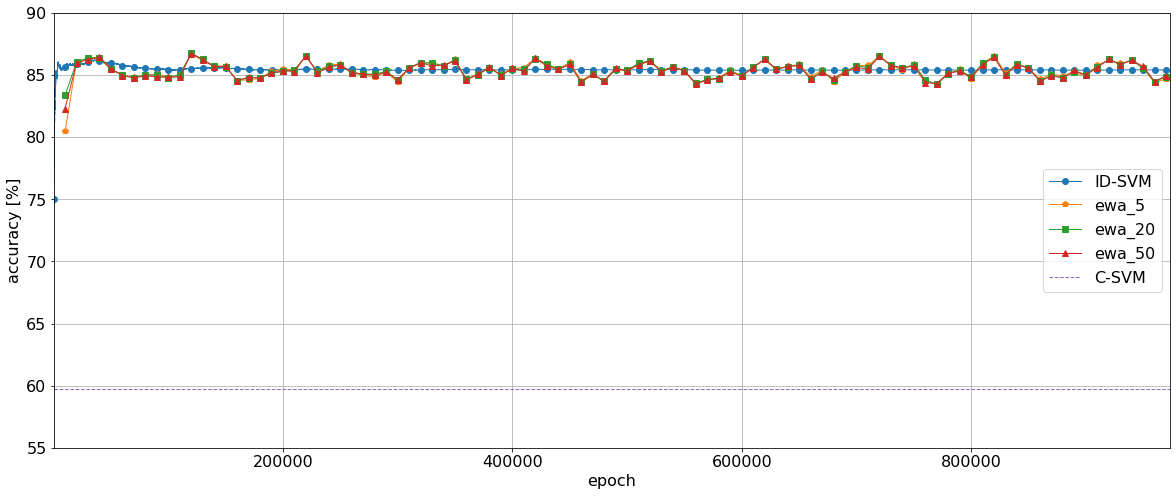

85.39760616157484

In [151]:
# represent running accuracy
x = np.array(range(int(res[0, 0]), int(res[0, 0] + res.shape[0])))
y = res[:, 1].copy().astype(np.float)

tot = 1
acc = y[0] 
for i in range(1, len(x)):
    tot += 1
    acc += y[i]
    y[i] = acc * 100 / tot
    
sx, sy_ewa_50 = decimate(x, y_ewa_50, 10000)
_, sy_ewa_20 = decimate(x, y_ewa_20, 10000)
_, sy_ewa_5 = decimate(x, y_ewa_5, 10000)

# plot the entire data
rcParams.update({'font.size': 16})
mke = range(x[0], x[-1], 10000)
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(x, y, lw=1, linestyle='-', marker='o', markevery=mke)
# ax.plot(x, sy_ewa_100, lw=1, linestyle='-', marker='d', markevery=mke)
# ax.plot(x, y_ewa_50, lw=0, linestyle='-', marker='^', markevery=mke)
# ax.plot(x, y_ewa_20, lw=0, linestyle='-', marker='s', markevery=mke)
# ax.plot(x, y_ewa_5, lw=0, linestyle='-', marker='p', markevery=mke)
ax.plot(sx, sy_ewa_5, lw=1, linestyle='-', marker='p', markevery=1)
ax.plot(sx, sy_ewa_20, lw=1, linestyle='-', marker='s', markevery=1)
ax.plot(sx, sy_ewa_50, lw=1, linestyle='-', marker='^', markevery=1)
ax.plot([x[0], x[-1]], [c_svm, c_svm], linestyle='--', lw=1)
ax.set_xlim([x[0], x[-1]])
ax.set_ylim(55, 90)
ax.set_ylabel('accuracy [%]')
ax.set_xlabel('epoch')
ax.legend([f'ID-SVM', f'ewa_5', f'ewa_20', f'ewa_50', f'C-SVM'])
plt.grid(); plt.show()
y[-1]

# Comparative graphs for Forrest Covertype

In [2]:
classic = {}
classic[100] = np.array([1, 2, 2, 1, 1, 1, 2, 1, 2, 2])
classic[200] = np.array([4, 4, 3, 4, 6, 5, 3, 3, 4, 4])
classic[500] = np.array([23, 25, 25, 23, 19, 21, 16, 19, 18, 16])
classic[1000] = np.array([66, 69, 69, 70, 71, 69, 66, 67, 69, 69])
classic[1200] = np.array([103, 102, 98, 100, 101, 109, 95, 96, 94, 97])
classic[1500] = np.array([147, 145, 151, 153, 159, 148, 150, 151, 159, 163])
classic[1700] = np.array([192, 196, 194, 187, 195, 196, 201, 197, 203, 210])
classic[2000] = np.array([267, 261, 266, 268, 271, 271, 268, 252, 238, 236])

In [3]:
window = {}
window[100] = np.array([2, 2, 2, 2, 1, 2, 2, 2, 2, 1])
window[200] = np.array([4, 4, 4, 3, 3, 3, 3, 3, 3, 3])
window[500] = np.array([8, 9, 10, 11, 11, 11, 11, 10, 10, 9])
window[1000] = np.array([45, 47, 37, 34, 35, 37, 36, 35, 36, 36])
window[1200] = np.array([10, 16, 23, 35, 37, 38, 42, 42, 45, 46])
window[1500] = np.array([80, 90, 86, 85, 85, 87, 88, 88, 90, 92])
window[1700] = np.array([49, 97, 99, 104, 110, 103, 106, 109, 110, 115])
window[2000] = np.array([145, 190, 160, 169, 171, 164, 167, 179, 191, 190])

In [4]:
from scipy.interpolate import UnivariateSpline

c = [(k, v.mean(), v.std()) for k, v in classic.items()]
w = [(k, v.mean(), v.std()) for k, v in window.items()]

x = [k[0] for k in c]
y_c = [k[1] for k in c]
y_w = [k[1] for k in w]
f_c = UnivariateSpline(x, y_c)
f_c.set_smoothing_factor(0.5)
f_w = UnivariateSpline(x, y_w)
f_w.set_smoothing_factor(1000)

x_c = np.linspace(100, 2000, 1901)
y_fc = f_c(x_c)
y_fw = f_w(x_c)

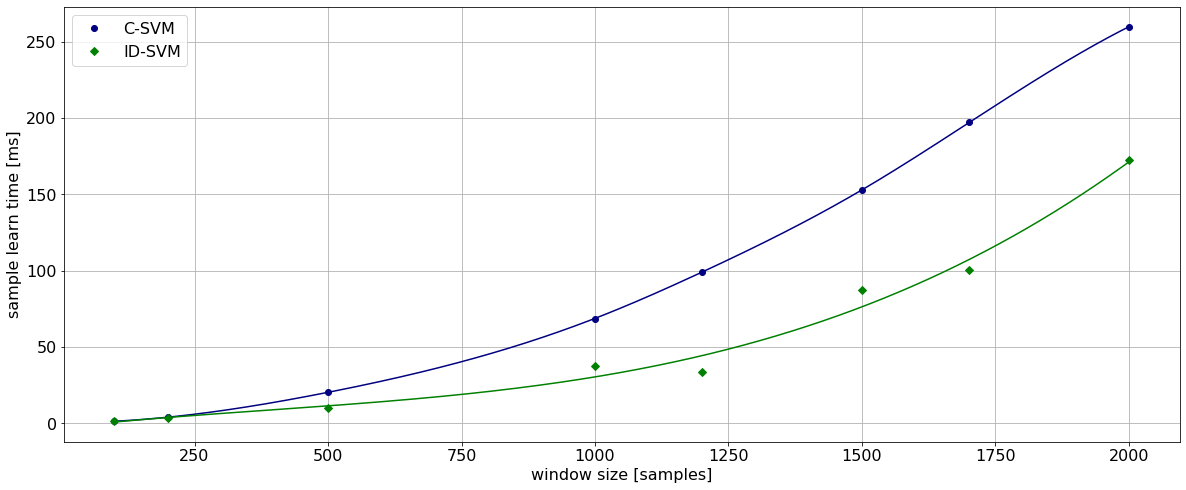

In [30]:
rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(x_c, y_fc, '-', c='navy')
a, = ax.plot(x, y_c, 'o', c='navy')
ax.plot(x_c, y_fw, '-', c='green')
b, = ax.plot(x, y_w, 'D', c='green')
ax.set_xlabel('window size [samples]')
ax.set_ylabel('sample learn time [ms]')
a.set_label('C-SVM')
b.set_label('ID-SVM')
ax.legend()
ax.grid() ; plt.show()

In [31]:
c

[(100, 1.5, 0.5),
 (200, 4.0, 0.8944271909999159),
 (500, 20.5, 3.2326459750489227),
 (1000, 68.5, 1.5652475842498528),
 (1200, 99.5, 4.272001872658765),
 (1500, 152.6, 5.589275444992848),
 (1700, 197.1, 6.0074953183502355),
 (2000, 259.8, 12.56821387469198)]

In [33]:
w

[(100, 1.8, 0.4),
 (200, 3.3, 0.45825756949558405),
 (500, 10.0, 1.0),
 (1000, 37.8, 4.214261501141095),
 (1200, 33.4, 11.984990613262907),
 (1500, 87.1, 3.207802986469088),
 (1700, 100.2, 17.825823964125757),
 (2000, 172.6, 14.235167719419396)]